## Notebook for statistical analysis of the "higher methane" setup

Figures produced here are obtainable through the makefigures script

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize as scopt
import scipy.stats as stats
import scipy.integrate as scint
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
## Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

palette = sns.color_palette('colorblind')

mpl.rc('axes', labelsize=7)
mpl.rc('legend', fontsize=7)
mpl.rc('xtick', labelsize=5.5)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=5.5)
mpl.rc('text',usetex=False)

labelsDict = {'FH2':r'$\Phi_{\mathregular{H_2}}$','FCO2':r'$\Phi_{\mathregular{CO_2}}$','FCH4':r'$\Phi_{\mathregular{CH_4}}$',
              'R1':r'$\mathregular{H_2}:\mathregular{CH_4}$','R2':r'$R_2$'}

import pyabc
import tempfile
import os

# Custom imports
import pyEnceladus.universal_htv as uhtv
import pyEnceladus.data_htv as dhtv
import pyEnceladus.physical as phc
import pyEnceladus.plot_tools as cplt
import pyEnceladus.stats_analysis as homestats
from pyEnceladus.biosims import makePriors, makeOnePrior
from pyEnceladus.plot_abc import confusion_format
import pyEnceladus.simulation_qstar as smqs
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os
palette = sns.color_palette('colorblind')

In [2]:
## load simulations and observations
dirname = 'higher_methane'
rootdir = os.path.join('data',dirname)
priors = pd.read_csv(os.path.join(rootdir,dirname+'.prior.csv'),delimiter=';',index_col=0)
outcomes = pd.read_csv(os.path.join(rootdir,'000/core_batch_000raw.csv'),delimiter=';',index_col=0)

observations    = pd.read_csv('data/observations/observations.csv',delimiter=';',index_col=0)
logobservations = pd.read_csv('data/observations/logobservations.csv',delimiter=';',index_col=0)
observation     = np.load('data/observations/observation.npy',allow_pickle=True)

reftable_data = np.load(os.path.join(rootdir,"reftable_data_standard.npy"),allow_pickle=True).item()
reftable_ref = np.load(os.path.join(rootdir,"reftable_ref_standard.npy"),allow_pickle=True)
testtable_data = np.load(os.path.join(rootdir,"testtable_data_standard.npy"),allow_pickle=True).item()
testtable_ref = np.load(os.path.join(rootdir,"testtable_ref_standard.npy"),allow_pickle=True)

total_table = pd.read_csv(os.path.join(rootdir,"total_table.csv"),delimiter=';')
training_df = pd.DataFrame(data=reftable_data)
test_df = pd.DataFrame(data=testtable_data)

bootstrap = np.load(os.path.join(rootdir,"bootstrap_standard.npy"),allow_pickle=True).item()

## Working on a simulation pool

In [3]:
timec = 60*60*24*365
observables_abiotic = pd.DataFrame(data={'FH2':outcomes['H2_ab']*timec,
                                         'FCH4':outcomes['CH4_ab']*timec,
                                         'R1':outcomes['H2_ab']/outcomes['CH4_ab']})
model = np.array(['uninhabitable','habitable'],dtype='str')[np.array(outcomes['H2']!=outcomes['H2_ab'],dtype=int)]
colors = {'uninhabitable':palette[0],
          'habitable':palette[1],
          'inhabited':palette[2]}
c = [colors[k] for k in model]
labels =  {'FH2':r'$\Phi_{\mathregular{H_2}}$','FCO2':r'$\Phi_{\mathregular{CO_2}}$','FCH4':r'$\Phi_{\mathregular{CH_4}}$','R1':r'$\mathregular{H_2}:\mathregular{CH_4}$','R2':r'$R_2$',
           'H2f':r'$[\mathregular{H_2}]_f$','CO2f':r'$[\mathregular{CO_2}]_f$','CH4f':r'$[\mathregular{CH_4}]_f$',
           'H2o':r'$[\mathregular{H_2}]_o$','CO2o':r'$[\mathregular{CO_2}]_o$','CH4o':r'$[\mathregular{CH_4}]_o$',
           'Tf':r'$T_f$'}

In [4]:
# Fraction of 'habitable simulations'
np.sum(model=='habitable')/len(model)

0.26716

### Plotting simulated observations vs internal parameters

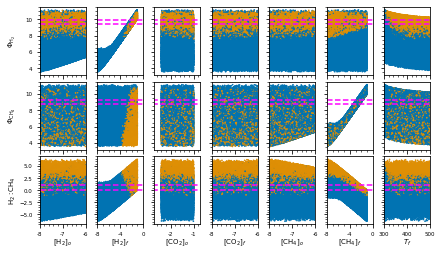

In [5]:
# 100% abiotic case
#
keys1 = list(priors.keys())
keys2 = list(observables_abiotic.keys())
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        if keys1[j] == 'Tf':
            axes[i,j].plot([300,500],[logobservations[keys2[i]]]*2,'--',color='magenta')
            axes[i,j].scatter(priors[keys1[j]],np.log10(observables_abiotic[keys2[i]]),s=0.5,c=c)
            axes[i,j].set_xlim(300,500)
            axes[i,j].set_xticks([300,400,500])
            axes[i,j].set_xticklabels(['300','400','500'])
        else:
            axes[i,j].plot([-8,0],[logobservations[keys2[i]]]*2,'--', color='magenta')
            axes[i,j].scatter(np.log10(priors[keys1[j]]),np.log10(observables_abiotic[keys2[i]]),s=0.5,c=c)
            if keys1[j] in ['H2o','CO2f','CH4o']:
                axes[i,j].set_xticks([-8,-7,-6])
                axes[i,j].set_xticklabels(['-8','-7','-6'])
                axes[i,j].set_xlim(-8,-6)
            elif keys1[j] == 'CH4f':
                axes[i,j].set_xticks([-8,-4,-0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
            elif keys1[j] == 'CO2o':
                axes[i,j].set_xticks([-2,-1])
                axes[i,j].set_xticklabels(['-2','-1'])
                axes[i,j].set_xlim(-2.7,-0.7)
            else:
                axes[i,j].set_xticks([-8,-4,0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]],labelpad=1)
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]],labelpad=1)
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.align_labels(axes)
plt.savefig('figures/inflow_moremeth.svg',dpi=400,bbox_inches = 'tight')
plt.show()

In [5]:
# Re-building the table of simulations with 100% of inhabited habitable simulations
observables_biotic = pd.DataFrame(data={'FH2':outcomes['H2']*timec,
                                        'FCH4':outcomes['CH4']*timec,
                                        'R1':outcomes['H2']/outcomes['CH4']})
model2 = np.array(['uninhabitable','inhabited'],dtype='str')[np.array(outcomes['H2']!=outcomes['H2_ab'],dtype=int)]
colors = {'uninhabitable':palette[0],
          'habitable':palette[1],
          'inhabited':palette[2]}
c2 = [colors[k] for k in model2]
labels =  {'FH2':r'$\Phi_{\mathregular{H_2}}$','FCO2':r'$\Phi_{\mathregular{CO_2}}$','FCH4':r'$\Phi_{\mathregular{CH_4}}$','R1':r'$\mathregular{H_2}:\mathregular{CH_4}$','R2':r'$R_2$',
           'H2f':r'$[\mathregular{H_2}]_f$','CO2f':r'$[\mathregular{CO_2}]_f$','CH4f':r'$[\mathregular{CH_4}]_f$',
           'H2o':r'$[\mathregular{H_2}]_o$','CO2o':r'$[\mathregular{CO_2}]_o$','CH4o':r'$[\mathregular{CH_4}]_o$',
           'Tf':r'$T_f$'}

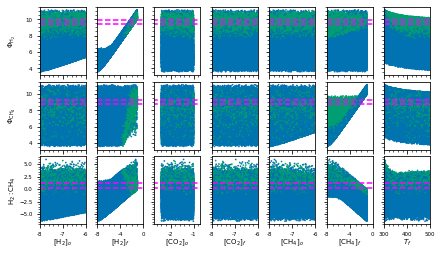

In [7]:
keys1 = list(priors.keys())
keys2 = list(observables_biotic.keys())
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        if keys1[j] == 'Tf':
            axes[i,j].plot([300,500],[logobservations[keys2[i]]]*2,'--', color='magenta')
            axes[i,j].scatter(priors[keys1[j]],np.log10(observables_biotic[keys2[i]]),s=0.5,c=c2)
            axes[i,j].set_xlim(300,500)
            axes[i,j].set_xticks([300,400,500])
            axes[i,j].set_xticklabels(['300','400','500'])
        else:
            axes[i,j].plot([-8,0],[logobservations[keys2[i]]]*2,'--', color='magenta')
            axes[i,j].scatter(np.log10(priors[keys1[j]]),np.log10(observables_biotic[keys2[i]]),s=0.5,c=c2)
            if keys1[j] in ['H2o','CO2f','CH4o']:
                axes[i,j].set_xticks([-8,-7,-6])
                axes[i,j].set_xticklabels(['-8','-7','-6'])
                axes[i,j].set_xlim(-8,-6)
            elif keys1[j] == 'CH4f':
                axes[i,j].set_xticks([-8,-4,0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
            elif keys1[j] == 'CO2o':
                axes[i,j].set_xticks([-2,-1])
                axes[i,j].set_xticklabels(['-2','-1'])
                axes[i,j].set_xlim(-2.7,-0.7)
            else:
                axes[i,j].set_xticks([-8,-4,0])
                axes[i,j].set_xticklabels(['-8','-4','0'])
                axes[i,j].set_xlim(-8,0)
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]],labelpad=1)
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]],labelpad=1)
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())    
            
            
#plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.align_labels(axes)
plt.savefig('figures/inflow_moremeth_bio.svg',dpi=400,bbox_inches='tight')
plt.show()

In [6]:
# Build the classifier
rfcl = RandomForestClassifier(random_state=0,n_estimators=500,criterion='gini',max_depth=20,
                              max_features=3,warm_start=False,min_samples_leaf=10,min_samples_split=100,
                              bootstrap=True,max_leaf_nodes=None,oob_score=True)

In [7]:
# Fit
rfcl.fit(training_df, reftable_ref)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [8]:
# Classifier score on the test table
rfcl.score(test_df,testtable_ref)

0.9081

In [9]:
# Classifier prediction on observations
rfcl.predict(observations)

array(['habitable', 'inhabited'], dtype='<U13')

In [10]:
# Classifier mean posterior probability for [habitable,inhabited,uninhabitable]
probs = rfcl.predict_proba(observations)
mprob = np.mean(probs,axis=0)
mprob

array([0.31525697, 0.60626281, 0.07848022])

In [13]:
# Manual cross-validation : prediction on the test table
crossvalid = rfcl.predict(test_df)

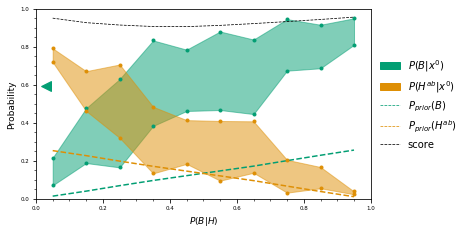

In [14]:
# NB: yields a different figure from the paper because the file was regenerated, the old is bootstrap_highermeth_og.npy
mpl.rc('axes', labelsize=9)
fig  = plt.figure(figsize=(6,3.5))
#ax   = plt.axes([0.1,0,1,0.8])
ax = fig.add_subplot(1,1,1)
MinP = np.min(np.array(bootstrap['probabilities'])[:,:,1],axis=1) # lower values of posterior probabilities
MaxP = np.max(np.array(bootstrap['probabilities'])[:,:,1],axis=1) # higher values
ax.plot(bootstrap['PIH'],MinP,'.',color=palette[2])
ax.plot(bootstrap['PIH'],MaxP,'.',color=palette[2])
ax.fill_between(bootstrap['PIH'],MaxP,MinP,color=palette[2],alpha=0.5) # plot the area
ax.plot(bootstrap['PIH'],bootstrap['PI'],'--',color=palette[2])

MinPh = np.min(np.array(bootstrap['probabilities'])[:,:,0],axis=1)
MaxPh = np.max(np.array(bootstrap['probabilities'])[:,:,0],axis=1)
ax.plot(bootstrap['PIH'],MinPh,'.',color=palette[1])
ax.plot(bootstrap['PIH'],MaxPh,'.',color=palette[1])
ax.fill_between(bootstrap['PIH'],MaxPh,MinPh,color=palette[1],alpha=0.5)


PH = np.sum(outcomes['CH4_ab'] != outcomes['CH4'])/len(outcomes)
meanPI = np.mean(np.array(bootstrap['probabilities'])[:,:,1])

ax.plot(bootstrap['PIH'],PH-np.array(bootstrap['PI']),'--',color=palette[1])

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.plot(bootstrap['PIH'],bootstrap['score'],'--k',linewidth=0.75)
ax.plot([0.03],[meanPI],marker='<',color=palette[2],markersize=10)


ax.set_ylim(0,1)
ax.set_xlim(0,1)


handles = [mpatches.Patch(color=palette[2]),mpatches.Patch(color=palette[1])]
handles.append(mlines.Line2D([], [], color=palette[2],linestyle='--', linewidth=0.75))
handles.append(mlines.Line2D([], [], color=palette[1],linestyle='--', linewidth=0.75))

handles.append(mlines.Line2D([], [], color='k',linestyle='--', linewidth=0.75))
ax.legend(handles=handles,labels=[r'$P(B|x^0)$',r'$P(H^{ab}|x^0)$',r'$P_{prior}(B)$',r'$P_{prior}(H^{ab})$','score'],
          loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=10)
ax.set_xlabel(r'$P(B|H)$')
ax.set_ylabel('Probability')


#plt.tight_layout()
plt.savefig('figures/bootstrap_highermeth.svg',dpi=400,bbox_inches = 'tight')

plt.show()

In [15]:
np.min(bootstrap['score'])

0.9049

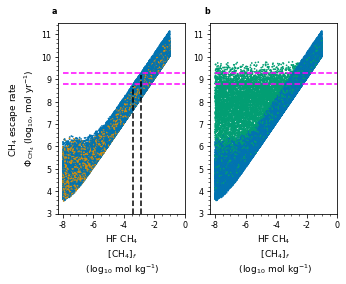

In [17]:
mpl.rc('axes', labelsize=9)
mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=8)
fig,axes = plt.subplots(figsize=(5,3.5),ncols=2)
axes[0].scatter(np.log10(priors['CH4f']),np.log10(observables_abiotic['FCH4']),s=0.5,c=c,rasterized=True)
axes[0].plot([-8,0],[logobservations['FCH4']]*2,'--', color='magenta')
axes[0].plot([-3.4]*2,[3,np.min(logobservations['FCH4'])-0.1],'--', color='black')
axes[0].plot([-2.9]*2,[3,np.max(logobservations['FCH4'])-0.1],'--', color='black')
axes[0].set_xticks([-8,-6,-4,-2,0])
axes[0].set_xticklabels(['-8','-6','-4','-2','0'])
axes[0].set_xlim(-8.3,0)
axes[0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0].yaxis.set_minor_locator(AutoMinorLocator())
axes[0].set_xlabel('HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10}~\mathregular{mol}~\mathregular{kg}^{-1}$)')
axes[0].set_ylabel('$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)')

axes[0].text(-0.05,1.05,'a',transform=axes[0].transAxes,fontsize=8,weight='bold')


axes[1].scatter(np.log10(priors['CH4f']),np.log10(observables_biotic['FCH4']),s=0.5,c=c2,rasterized=True)
axes[1].plot([-8,0],[logobservations['FCH4']]*2,'--', color='magenta')
axes[1].set_xticks([-8,-6,-4,-2,0])
axes[1].set_xticklabels(['-8','-6','-4','-2','0'])
axes[1].set_xlim(-8.3,0)
axes[1].xaxis.set_minor_locator(AutoMinorLocator())
axes[1].yaxis.set_minor_locator(AutoMinorLocator())
axes[1].set_xlabel('HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10}~\mathregular{mol}~\mathregular{kg}^{-1}$)')
#axes[1].set_ylabel('$\Phi_{\mathregular{CH}_4}$ ($\log_{10}$)')

axes[0].set_ylim(3,11.5)
axes[1].set_ylim(3,11.5)


axes[0].text(-0.05,1.05,'b',transform=axes[1].transAxes,fontsize=8,weight='bold')


plt.savefig('figures/inflowCH4_highermeth.svg',dpi=400,bbox_inches = 'tight')
plt.show()

In [18]:
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=5.5)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=5.5)

In [19]:
## Mean posterior value of P(I|x)
np.mean(np.array(bootstrap['probabilities'])[:,:,1])

0.5905634132996898

In [20]:
## Playing with non-uniform prior P(I)
m = np.average(np.array(bootstrap['probabilities'])[:,:,1],
               axis=0,
               weights = [np.exp(-0.2*i) for i in range(len(np.array(bootstrap['probabilities'])))])
np.mean(m)

0.47002269348940523

In [21]:
def Likelihood(outputs,observations,observables,scale):
    """
    Returns the so-called normalized likelihoods (an estimate)
    of the different models given observations
    """
    Likelyhood = []
    for var in observables:
        distr = np.array(outputs[var])
        Lfun = stats.gaussian_kde(distr)
        Lfun_weighed = lambda x : Lfun(x)*scale
        xobsmin = np.min(observations[var])
        xobsmax = np.max(observations[var])
        e = (xobsmax-xobsmin)/2
        xobs = np.mean(observations[var])
        NLi  = scint.quad(Lfun_weighed,xobs-e,xobs+e)[0]
        if NLi >1:
            print('warning : N Likelyhood greater than 1 ({})! This may be due to numerical integration'.format(NLi))
            NLi = 1.0
        Likelyhood.append(NLi)
    return(Likelyhood)

def autolabel(rects,bottom,fontsize,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+bottom
        if height < 0.01 and height > 0.001:
            text = '< 1%'
        elif height < 0.001:
            text = r'$\approx 0$'
        else:
            text = np.round(rect.get_height(),2)
        ax.annotate('{}'.format(text),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=fontsize)

In [22]:
var_order = np.array(['FH2','FCH4','R1'])
#var_order = list(logobservations.keys())
PI = len(total_table[total_table['model']==2])/len(total_table)
PH = len(total_table[total_table['model']==1])/len(total_table)
PU = len(total_table[total_table['model']==0])/len(total_table)

inh_L = np.array(Likelihood(total_table[total_table['model']==2],logobservations,observables=var_order,scale=PI))
hab_L = np.array(Likelihood(total_table[total_table['model']==1],logobservations,observables=var_order,scale=PH))
uni_L = np.array(Likelihood(total_table[total_table['model']==0],logobservations,observables=var_order,scale=PU))

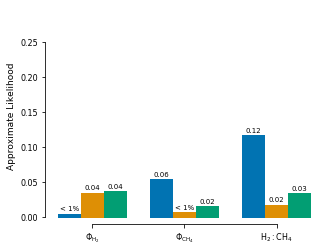

In [23]:
mpl.rc('axes', labelsize=9)
mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=8)
fig,ax =plt.subplots(figsize=(5,4))
Xticks = [labelsDict[k] for k in var_order]
X = np.array([1,2,3])
width=0.25
bottom = -0.001
Urect = ax.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
Hrect = ax.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
Irect = ax.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
f = 7
autolabel(Urect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Irect,bottom=bottom,fontsize=f,ax=ax)
ax.set_xticks([1,2,3])
ax.set_xticklabels(Xticks)
ax.set_ylim(-0.01,.3)
sns.despine(ax=ax,trim=True,left=False)
ax.set_ylabel('Approximate Likelihood')
plt.savefig(os.path.join(rootdir,'figures','likelihood_hm05.svg'),dpi=400)
plt.show()

In [24]:
inhabited_data = total_table[total_table['model']==2][['R1','FH2','FCH4']]
habitable_data = total_table[total_table['model']==1][['R1','FH2','FCH4']]
uninhabit_data = total_table[total_table['model']==0][['R1','FH2','FCH4']]

homestats.get_Nli_range(inhabited_data,'FCH4',logobservations)

{'var': 'FCH4',
 'NL': 0.7378940100422552,
 'maxL': 8.305127688315151,
 'width': 0.2385606273598313,
 'obs': array([8.7998366 , 9.27695786]),
 'kernel': <scipy.stats.kde.gaussian_kde at 0x11bc7b250>}

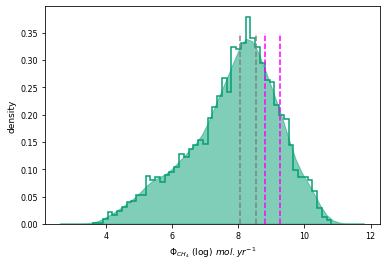

In [25]:
fig, ax = plt.subplots(figsize=(6,4))
cplt.plot_Likelihood(ax,inhabited_data,'FCH4',logobservations,
                topval=0.35,histtype='step',density=True,bins=50,color=palette[2],linewidth=1.5)
ax.set_xlabel(r'$\Phi_{CH_4}$ (log) $mol.yr^{-1}$')
ax.set_ylabel('density')
plt.show()

In [26]:
labelsDict =  {'FH2' :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCO2':'$\mathregular{CO_2}$ escape rate \n $\Phi_{\mathregular{CO_2}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCH4':'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'R1':'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
           'R2':r'$R_2$',
           'H2f':'HF $\mathregular{H_2}$ \n $[\mathregular{H_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2f':'HF $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4f':'HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'H2o' :'Ocean $\mathregular{H_2}$ \n $[\mathregular{H_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2o':'Ocean $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4o':'Ocean $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'Tf':'HF temperature \n $T_f$ (K)'}

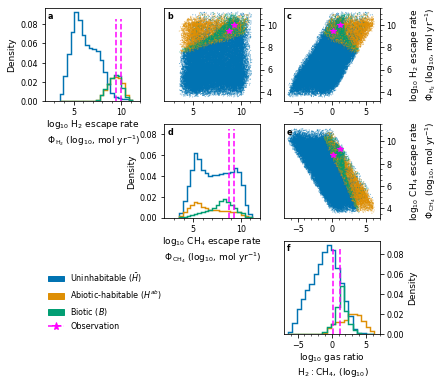

In [31]:
# Plot distributions of obervables, position of observations in the space of observables and the likelihood of the different scenarios
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(6,6),constrained_layout=False)
gs = fig.add_gridspec(3, 3)

variables = ['FH2','FCH4','R1']
barlabels = np.array([r'$H$',r'$I$',r'$\bar{H}$'])
palette = sns.color_palette('colorblind')
colors=[palette[total_table['model'].iloc[k]] for k in range(len(total_table))]

for i in range(3):
    for j in range(3):
        var = variables[i]
        var2 = variables[j]
        if var2 == 'R1':
            axes[i,j].set_xlim(-7,7)
        else:
            axes[i,j].set_xlim(2,12)
        if i==j:
            cplt.DistriPlot(ax=axes[i,j],data=total_table,var=var,Nbins=20,alpha=1,histtype='step',linewidth=1.45,palette=palette)
            axes[i,j].set_xlabel('$\log_{10}$ '+labelsDict[var],labelpad=1)
            axes[i,j].plot([logobservations[var]]*2,[0,0.085],linestyle='--',color='magenta')
        elif i < j:
            axes[i,j].scatter(total_table[var2],total_table[var],c=colors,marker='d',s=0.01,rasterized=True)
            axes[i,j].plot(logobservations[var2],logobservations[var],marker='*',linestyle='',color='magenta')
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        
axes[2,0].axis('off')
axes[2,1].axis('off')
axes[1,0].axis('off')

axes[0,0].set_ylabel('Density')
axes[0,1].yaxis.tick_right()
axes[0,2].yaxis.tick_right()
axes[0,2].yaxis.set_label_position("right")
axes[0,2].set_ylabel('$\log_{10}$ '+labelsDict[variables[0]])
axes[1,1].set_ylabel('Density')
axes[1,2].yaxis.tick_right()
axes[1,2].yaxis.set_label_position("right")
axes[1,2].set_ylabel('$\log_{10}$ '+labelsDict[variables[1]])

axes[2,2].yaxis.tick_right()
axes[2,2].yaxis.set_label_position("right")
axes[2,2].set_ylabel('Density')



cols  = [0,1,2]*2+ [0,2]
xlabc = [0.135,0.41,0.69]*2+[0.13,0.69]
rows  = np.repeat([0,1,2],[3,3,2])
ylabc = np.repeat([0.855,0.58,0.32,0.31],[3,3,1,1])



ax_boot = fig.add_subplot(gs[2,:2])
axes[2,1] = ax_boot
ax_boot.axis('off')
#width=0.3
#X = np.array([1,2,3])
#bottom = -0.001
#Urect = ax_boot.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
#Hrect = ax_boot.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
#Irect = ax_boot.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
#f = 6
#autolabel(Urect,bottom=bottom,fontsize=f,ax=ax_boot)
#autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax_boot)
#autolabel(Irect,bottom=bottom,fontsize=f,ax=ax_boot)

#ax_boot.set_ylim(-0.01,.3)
#ax_boot.set_xticks(X)
#ax_boot.set_xticklabels(Xticks,rotation=0,ha='center',fontsize=7)
#ax_boot.tick_params(axis='x', which='major', pad=12)
#ax_boot.set_ylabel('Likelihood')


#sns.despine(ax=ax_boot,trim=True,left=False)

labels = ['{0}'.format(letter) for letter in ['a','b','c','','d','e','','f']]
for i,j,z in [(0,0,0),(0,1,1),(0,2,2),(1,1,4),(1,2,5),(2,1,6),(2,2,7)]:
    axes[i,j].text(0.03,0.89,labels[z],transform=axes[i,j].transAxes,fontsize=8,weight='bold')
    
axes[0,1].yaxis.set_minor_locator(AutoMinorLocator())
axes[0,2].yaxis.set_minor_locator(AutoMinorLocator())
axes[1,2].yaxis.set_minor_locator(AutoMinorLocator())

uninh_patch = mpatches.Patch(color=palette[0], label=r'Uninhabitable ($\bar{H}$)')
habit_patch = mpatches.Patch(color=palette[1], label=r'Abiotic-habitable ($H^{ab}$)')
inhab_patch = mpatches.Patch(color=palette[2], label=r'Biotic ($B$)')
datap_line  = mlines.Line2D([], [], color='magenta', marker='*', linestyle='--', markersize=8, label='Observation')

axes[2,0].legend(handles = [uninh_patch, habit_patch, inhab_patch, datap_line],
                 fontsize=8,loc='lower left', borderaxespad=0, frameon=False)

fig.align_labels(axes[:,2])

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('figures/distributions_likelihood_highermeth.svg',dpi=400,bbox_inches = 'tight')
plt.show()

In [67]:
reftable_data_005 = np.load(os.path.join(rootdir,"reftable_data_005.npy"),allow_pickle=True).item()
reftable_ref_005 = np.load(os.path.join(rootdir,"reftable_ref_005.npy"),allow_pickle=True)
testtable_data_005 = np.load(os.path.join(rootdir,"testtable_data_005.npy"),allow_pickle=True).item()
testtable_ref_005 = np.load(os.path.join(rootdir,"testtable_ref_005.npy"),allow_pickle=True)

total_table_005 = pd.read_csv(os.path.join(rootdir,"total_table.csv"),delimiter=';')
training_df_005 = pd.DataFrame(data=reftable_data)
test_df_005 = pd.DataFrame(data=testtable_data)

total_table_005 = np.log10(pd.DataFrame(data=reftable_data_005))
total_table_005['models'] = reftable_ref_005
translate = {'uninhabitable':0,'habitable':1,'inhabited':2}
total_table_005['model'] = np.array([translate[total_table_005['models'].loc[i]] for i in range(len(total_table_005))])

In [68]:
var_order = np.array(['FH2','FCH4','R1'])
#var_order = list(logobservations.keys())
PI005 = len(total_table_005[total_table_005['model']==2])/len(total_table_005)
PH005 = len(total_table_005[total_table_005['model']==1])/len(total_table_005)
PU005 = len(total_table_005[total_table_005['model']==0])/len(total_table_005)
inh_L = np.array(Likelihood(total_table_005[total_table_005['model']==2],logobservations,observables=var_order,scale=PI005))
hab_L = np.array(Likelihood(total_table_005[total_table_005['model']==1],logobservations,observables=var_order,scale=PH005))
uni_L = np.array(Likelihood(total_table_005[total_table_005['model']==0],logobservations,observables=var_order,scale=PU005))

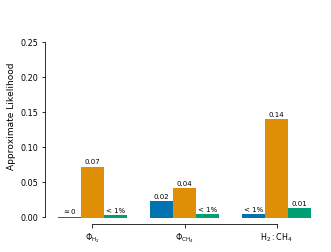

In [71]:

mpl.rc('axes', labelsize=9)
mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=8)
fig,ax =plt.subplots(figsize=(5,4))
Xticks = [labelsDict[k] for k in var_order]
X = np.array([1,2,3])
width=0.25
bottom = -0.001
Urect = ax.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
Hrect = ax.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
Irect = ax.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
f = 7
autolabel(Urect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Hrect,bottom=bottom,fontsize=f,ax=ax)
autolabel(Irect,bottom=bottom,fontsize=f,ax=ax)
ax.set_xticks([1,2,3])
ax.set_xticklabels(Xticks)
ax.set_ylim(-0.01,.3)
sns.despine(ax=ax,trim=True,left=False)
ax.set_ylabel('Approximate Likelihood')
plt.savefig(os.path.join(rootdir,'figures','likelihood_hm005.svg'),dpi=400)
plt.show()